# Newark Airport Performance
## Author: Kleen, Eric M.

#### The dataset for this analysis comes from the US Dept of Transportation website:
https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=237

# Overview

Because it is the holiday season and there is typically a lot of travel during this time of year, I wanted to analyze the performance of air travel into and out of Newark Liberty Airport. Ultimately, I wanted to develop a binary classification model which would determine he probability of a flight being delayed/cancelled based on historical data.  The steps below follow the CRISP-DM process to develop this model.

# 1) Understanding the Business

In order to develop the model, I first explored the following questions to understand the business I was attempting to model.

#### - Q1: What is the overall rate of delayed/cancelled flights departing EWR?
#### - Q2: What is the rate of delayed/cancelled flights departing EWR for each airline?
#### - Q3: Which airlines have the most flights and therefore the most influence on the overall delay rate?
#### - Q4: Is there monthly/weekly/daily seasonality?

# 2) Understanding the Data

In [1]:
#import libraries
import pandas as pd
import os
from os import listdir, path
import matplotlib.pyplot as plt
%matplotlib inline

#Define folder paths
root_folder = os.getcwd()
data_folder = path.join(root_folder, "Data Files")
lookup_folder = path.join(root_folder, "Lookup Files")

### Step 1: Review the published documentation

In [2]:
#Review the data profile sheet describing each column.  First 10 rows of profile sheet shown below.
pd.read_excel("Source Data Profile.xlsx", sheet_name="Profile").head(10)

,Column,Type,Description
0,Year,int64,Year
1,Quarter,int64,Quarter (1-4)
2,Month,int64,Month
3,DayofMonth,int64,Day of Month
4,DayOfWeek,int64,Day of Week
5,FlightDate,object,Flight Date (yyyymmdd)
6,UniqueCarrier,object,Unique Carrier Code. When the same code has be...
7,AirlineID,int64,An identification number assigned by US DOT to...
8,Carrier,object,Code assigned by IATA and commonly used to ide...
9,TailNum,object,Tail Number


### Step 2: Identify the desired columns and import the data

In [3]:
#Define list of columns to be used for analysis
cols = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 
        'MKT_UNIQUE_CARRIER', 'MKT_CARRIER_FL_NUM', 'TAIL_NUM', 'ORIGIN', 'DEST', 
        'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 
        'CANCELLED', 'DISTANCE']

In [4]:
#The data source contains monthly files.  Read each file and create a master DataFrame object.
df = pd.DataFrame()
lstFiles = [f for f in listdir(data_folder)]
for f in lstFiles:
    try:
        df_in = pd.read_csv(path.join(data_folder, f), usecols=cols)
        df = pd.concat([df, df_in], axis=0, sort=False)
        print("{0} rows imported from <{1}> and added to DataFrame.".format(df_in.shape[0], f))
    except:
        print("**Warning, an error occurred while importing file <{0}>".format(f))
print("DataFrame contains {0} rows and {1} columns.".format(df.shape[0], df.shape[1]))

27761 rows imported from <2019-Apr.csv> and added to DataFrame.
28721 rows imported from <2019-Aug.csv> and added to DataFrame.
28112 rows imported from <2019-Dec.csv> and added to DataFrame.
23894 rows imported from <2019-Feb.csv> and added to DataFrame.
25878 rows imported from <2019-Jan.csv> and added to DataFrame.
28378 rows imported from <2019-Jul.csv> and added to DataFrame.
27468 rows imported from <2019-Jun.csv> and added to DataFrame.
28024 rows imported from <2019-Mar.csv> and added to DataFrame.
28099 rows imported from <2019-May.csv> and added to DataFrame.
27069 rows imported from <2019-Nov.csv> and added to DataFrame.
29198 rows imported from <2019-Oct.csv> and added to DataFrame.
27279 rows imported from <2019-Sep.csv> and added to DataFrame.
DataFrame contains 329881 rows and 18 columns.


### Step 3: Inspect the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329881 entries, 0 to 27278
Data columns (total 18 columns):
YEAR                  329881 non-null int64
MONTH                 329881 non-null int64
DAY_OF_MONTH          329881 non-null int64
DAY_OF_WEEK           329881 non-null int64
FL_DATE               329881 non-null object
MKT_UNIQUE_CARRIER    329881 non-null object
MKT_CARRIER_FL_NUM    329881 non-null int64
TAIL_NUM              325803 non-null object
ORIGIN                329881 non-null object
DEST                  329881 non-null object
CRS_DEP_TIME          329881 non-null int64
DEP_TIME              319971 non-null float64
DEP_DELAY             319971 non-null float64
CRS_ARR_TIME          329881 non-null int64
ARR_TIME              319466 non-null float64
ARR_DELAY             318327 non-null float64
CANCELLED             329881 non-null float64
DISTANCE              329881 non-null float64
dtypes: float64(6), int64(7), object(5)
memory usage: 47.8+ MB


In [6]:
#Define categorical and numeric fields
cat_list = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 
        'MKT_UNIQUE_CARRIER', 'MKT_CARRIER_FL_NUM', 'TAIL_NUM', 'ORIGIN', 'DEST', 
        'CRS_DEP_TIME', 'DEP_TIME', 'CRS_ARR_TIME', 'ARR_TIME',  
        'CANCELLED']
num_list = ['DEP_DELAY', 'ARR_DELAY', 'DISTANCE']

In [7]:
#This is analysis focuses on Newark (EWR) departures which is makes up the majority of the dataset
df['ORIGIN'].value_counts()

EWR    158827
MCO      8122
ATL      7038
FLL      6028
SFO      5803
        ...  
LEX        35
HHH        35
HDN        24
RAP        22
RNO         1
Name: ORIGIN, Length: 99, dtype: int64

In [8]:
#There are over 10,000 total cancelled flights.  Every row contains either a '0' or '1'
df['CANCELLED'].value_counts()

0.0    319605
1.0     10276
Name: CANCELLED, dtype: int64

In [9]:
#Investigate missing data.  Look at the data set where nulls occur and try to identify a reason for the
#missing data and whether or not we can impute values using mode, mean, etc.

#This is one example, I have identified that the TAIL_NUM field is only null for Cancelled flights, 
#but not all cancelled flights are null.
df[df['TAIL_NUM'].isnull()]['CANCELLED'].value_counts()

1.0    4078
Name: CANCELLED, dtype: int64

In [10]:
#Review numerical values.
df[num_list].describe().T

,count,mean,std,min,25%,50%,75%,max
DEP_DELAY,319971.0,21.723409,67.726724,-40.0,-6.0,-2.0,21.0,1839.0
ARR_DELAY,318327.0,16.946715,70.388196,-83.0,-16.0,-4.0,23.0,1844.0
DISTANCE,329881.0,986.652420,710.233654,143.0,488.0,748.0,1167.0,4962.0


### Step 4: Review lookup file.

In [11]:
#The dataset also includes a lookup file containing Airline names
df_lu = pd.read_csv(path.join(lookup_folder, 'l_unique_carriers.csv'))
df_lu.head(10)

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.
5,09Q,"Swift Air, LLC d/b/a Eastern Air Lines d/b/a E..."
6,0BQ,DCA
7,0CQ,ACM AIR CHARTER GmbH
8,0FQ,"Maine Aviation Aircraft Charter, LLC"
9,0GQ,"Inter Island Airways, d/b/a Inter Island Air"


In [12]:
#Inspecting the data reveals 1 null value in the Code column which is used to join the data so this needs to be looked into.
df_lu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 2 columns):
Code           1675 non-null object
Description    1676 non-null object
dtypes: object(2)
memory usage: 26.3+ KB


In [13]:
#Looking at the original data file, the Code value for this row should be "NA" which is interpreted by Python as NaN.
df_lu[df_lu['Code'].isnull()]

,Code,Description
1010,NaN,North American Airlines


In [14]:
#Changing the 'keep_default_na' parameter allows Python to read the value "NA"
df_lu = pd.read_csv(path.join(lookup_folder, 'l_unique_carriers.csv'), keep_default_na=False)
df_lu[df_lu['Code'].isnull()]

,Code,Description


# 3) Preparing the Data

### Step 1: Import the data

In [15]:
#Define data types for each field (note: date fields will be parsed during read operation).
cols = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 
        'MKT_UNIQUE_CARRIER', 'MKT_CARRIER_FL_NUM', 'TAIL_NUM', 'ORIGIN', 'DEST', 
        'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 
        'CANCELLED', 'DISTANCE']
types = {'YEAR':'int', 'MONTH':'int', 'DAY_OF_MONTH':'int', 'DAY_OF_WEEK':'int', 
         'MKT_UNIQUE_CARRIER':'str', 'MKT_CARRIER_FL_NUM':'str', 'TAIL_NUM':'str', 'ORIGIN':'str', 
         'DEST':'str', 'CRS_DEP_TIME':'str', 'DEP_TIME':'str', 'DEP_DELAY':'float', 
         'CRS_ARR_TIME':'str', 'ARR_TIME':'str', 'ARR_DELAY':'float', 'CANCELLED':'int', 
         'CANCELLATION_CODE':'str', 'DISTANCE':'float'}

In [16]:
#Import the data using specified data types.
#Data contains all NJ airports, but only flights in/out of Newark Liberty (EWR) are needed for this analysis.
df_flts = pd.DataFrame()
lstFiles = [f for f in listdir(data_folder)]
for f in lstFiles:
    try:
        df_in = pd.read_csv(path.join(data_folder, f), usecols=cols, dtype=types, parse_dates=['FL_DATE'])
        df_in = df_in[(df_in['ORIGIN']=='EWR') | (df_in['DEST']=='EWR')].copy()
        df_flts = pd.concat([df_flts, df_in], axis=0, sort=False)
    except:
        print("**Warning, an error occurred while importing file <{0}>".format(f))
print("DataFrame contains {0} rows and {1} columns.".format(df_flts.shape[0], df_flts.shape[1]))

DataFrame contains 317631 rows and 18 columns.


In [17]:
#Import the lookup file.
f = 'l_unique_carriers.csv'
try:
    #Use 'keep_default_na=False' because one of the airline codes is 'NA'
    df_lu = pd.read_csv(path.join(lookup_folder, f), keep_default_na=False, index_col="Code")
except:
    print("**Warning, an error occurred while importing file <{0}>".format(f))
print("DataFrame contains {0} rows and {1} columns.".format(df_lu.shape[0], df_lu.shape[1]))

DataFrame contains 1676 rows and 1 columns.


In [18]:
#Join the airline name lookup table to the flight data.
df_lu.rename({'Description':'CARRIER_NAME'}, axis=1, inplace=True)
df = df_flts.join(df_lu, on='MKT_UNIQUE_CARRIER', how="left")
df[['MKT_UNIQUE_CARRIER', 'CARRIER_NAME']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317631 entries, 0 to 27278
Data columns (total 2 columns):
MKT_UNIQUE_CARRIER    317631 non-null object
CARRIER_NAME          317631 non-null object
dtypes: object(2)
memory usage: 7.3+ MB


### Step 2: Clean the data

In [19]:
#Sort and re-index flight data
df.sort_values(['FL_DATE', 'CRS_DEP_TIME', 'MKT_UNIQUE_CARRIER'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

#Arrange columns
df = df[['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'MKT_UNIQUE_CARRIER',  'CARRIER_NAME', 'MKT_CARRIER_FL_NUM', 'TAIL_NUM', 'ORIGIN',
       'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME',
       'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DISTANCE']]

In [20]:
#Remove all values fpr select fields in cancelled rows to standardize the data.
mask = df['CANCELLED']==1
clean_fields = ['TAIL_NUM', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME', 'ARR_DELAY']
for c in clean_fields:
    df.loc[mask, c]=None

#Create a categorical field for flights with a departure delay at least 30 minutes, 0='False' and 1='True'
df['DELAYED'] = 0
df.loc[(df['DEP_DELAY']>=30), 'DELAYED'] = 1

#Create a categorical field for flights with a departure delay at least 30 minutes OR cancelled, 0='False' and 1='True'
df['DEL_CANC'] = 0
df.loc[(df['DELAYED']==1) | (df['CANCELLED']==1), 'DEL_CANC'] = 1

#Create a categorical field for flight departure time block (6hr blocks)
def time_block(dep_time):
    """Return the 6-hr time block based on the departure time.
    
    Postional arguments:
    dep_time -- departure time of flight
    """
    if dep_time/100 < 6:
        return "00-06"
    elif dep_time/100 <12:
        return "06-12"
    elif dep_time/100 <18:
        return "12-18"
    elif dep_time/100 <=24:
        return "18-24"
df['DEP_BLOCK'] = df['CRS_DEP_TIME'].astype('int').apply(time_block)
print("DataFrame contains {0} rows and {1} columns.".format(df.shape[0], df.shape[1]))

DataFrame contains 317631 rows and 22 columns.


### Step 3: Explore the data

In [21]:
#Create function to be used for data exploration.
def f_del_flts(df_in, group_column, count_column, origin="EWR"):
    """Return an aggregated Series object with the % of total values.
    
    Positional arguments:
    df_in -- DataFrame object to aggregate
    group_column -- Column name to be used as Group By
    count_column -- Column name to be summarized
    origin -- Origin airport (default='EWR')
    """
    df_out = df_in[df_in['ORIGIN']==origin][[group_column, count_column]]
    df_out = df_out.groupby([group_column]).agg(['count', 'sum'])
    df_out = df_out[count_column]
    df_out['%'] = round(df_out['sum']/df_out['count']*100, 0).astype('int')
    return df_out['%']

##### Q1) What is the overall rate of delayed/cancelled flights departing EWR?

Analysis: On average, 2019 flights from EWR are delayed/cancelled about 22% of the time.

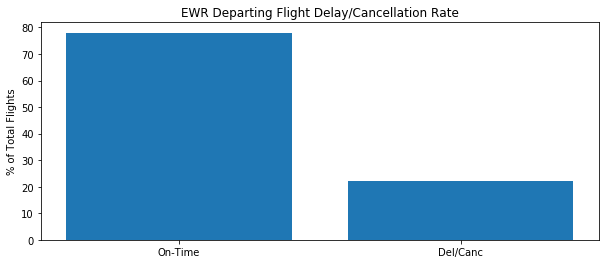

,FLIGHTS,%
DEL_CANC,,
On-Time,123095,78
Del/Canc,35732,22


In [22]:
mask = (df['ORIGIN']=="EWR")
del_flts = df[mask][['DEL_CANC', 'MKT_CARRIER_FL_NUM']].copy().groupby(['DEL_CANC']).count()
del_flts.rename({'MKT_CARRIER_FL_NUM':'FLIGHTS'}, inplace=True, axis=1)
del_flts['%'] = round(del_flts['FLIGHTS']/len(df[mask])*100, 0).astype('int')
del_flts.rename({0:'On-Time', 1:'Del/Canc'}, axis=0, inplace=True)
plt.figure(figsize=[10,4])
plt.title('EWR Departing Flight Delay/Cancellation Rate')
plt.ylabel('% of Total Flights')
plt.bar(del_flts.index, del_flts['%'])
plt.show()
del_flts

##### Q2) What is the rate of delayed/cancelled flights departing EWR for each airline?

Analysis: The delay rate by airline ranges from 8% to 30% with an average of 20%.  Frontier Airlines has the worst delay rate while Allegiant has the best.

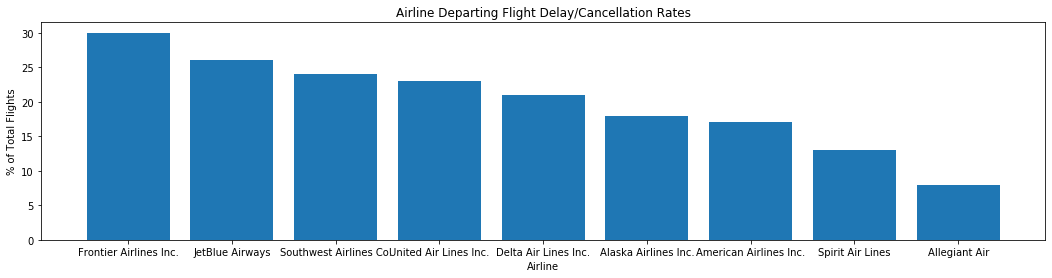

In [23]:
del_flts = f_del_flts(df.copy(), 'CARRIER_NAME', 'DEL_CANC').sort_values(ascending=False)
plt.figure(figsize=[18,4])
plt.title('Airline Departing Flight Delay/Cancellation Rates')
plt.xlabel('Airline')
plt.ylabel('% of Total Flights')
plt.bar(del_flts.index, del_flts)
plt.show()

In [24]:
del_flts.describe()

count     9.00000
mean     20.00000
std       6.78233
min       8.00000
25%      17.00000
50%      21.00000
75%      24.00000
max      30.00000
Name: %, dtype: float64

##### Q3) Which airlines have the most flights and therefore the most influence on the overall delay rate?

Analysis: By far, United Airlines has the most influence on the overall delay rate.

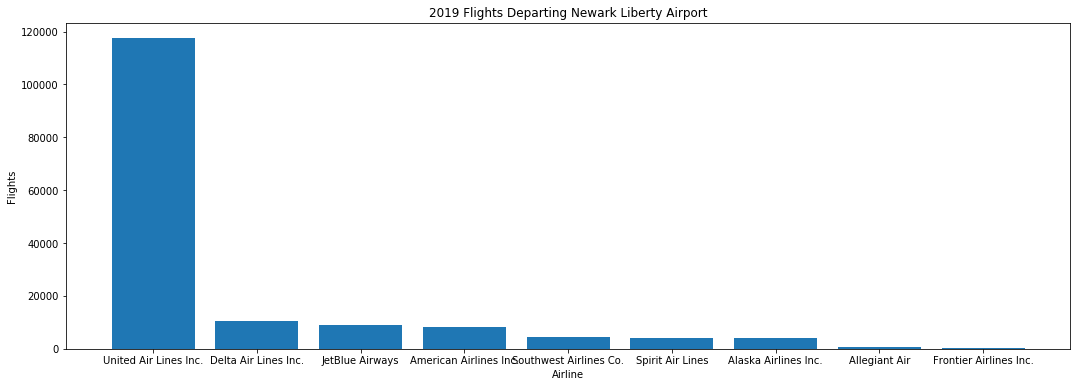

In [25]:
mask = (df['ORIGIN']=="EWR")
tot_flts = df[mask][['CARRIER_NAME', 'MKT_CARRIER_FL_NUM']].copy().groupby('CARRIER_NAME').count()
tot_flts.rename({'MKT_CARRIER_FL_NUM':'FLIGHTS'}, inplace=True, axis=1)
tot_flts.sort_values(by='FLIGHTS', ascending=False, inplace=True)
plt.figure(figsize=[18,6])
plt.title('2019 Flights Departing Newark Liberty Airport')
plt.xlabel('Airline')
plt.ylabel('Flights')
plt.bar(tot_flts.index, tot_flts['FLIGHTS'])
plt.show()

##### Q4) Is there monthly/weekly/daily seasonality?

Analysis:   
Monthly Response: The months of Jun-Aug appear to have an increased chance of delay.  
Weekly Response: Wed-Fri appear to have an increase chance of delay.  
Daily Response: The 18-24 time block is by far the worst time to fly.

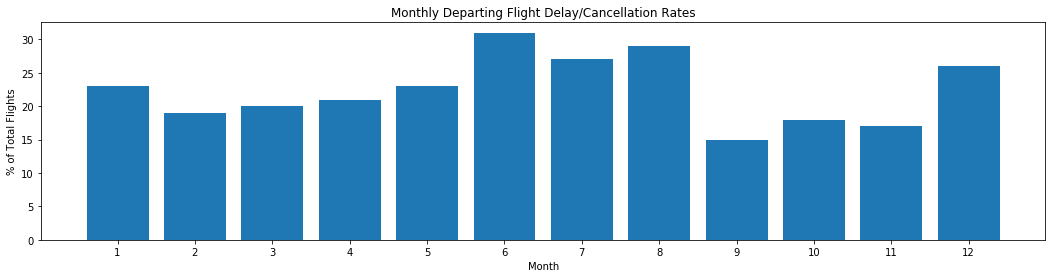

In [26]:
del_flts = f_del_flts(df.copy(), 'MONTH', 'DEL_CANC')
plt.figure(figsize=[18,4])
plt.title('Monthly Departing Flight Delay/Cancellation Rates')
plt.xlabel('Month')
plt.ylabel('% of Total Flights')
plt.bar(del_flts.index, del_flts)
plt.xticks(del_flts.index)
plt.show()

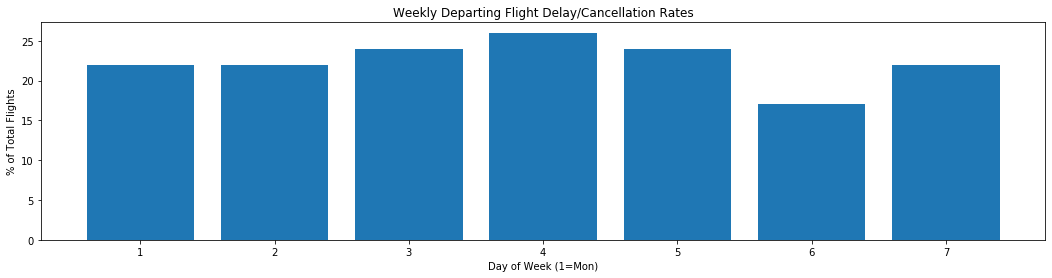

In [27]:
del_flts = f_del_flts(df.copy(), 'DAY_OF_WEEK', 'DEL_CANC')
plt.figure(figsize=[18,4])
plt.title('Weekly Departing Flight Delay/Cancellation Rates')
plt.xlabel('Day of Week (1=Mon)')
plt.ylabel('% of Total Flights')
plt.bar(del_flts.index, del_flts)
plt.xticks(del_flts.index)
plt.show()

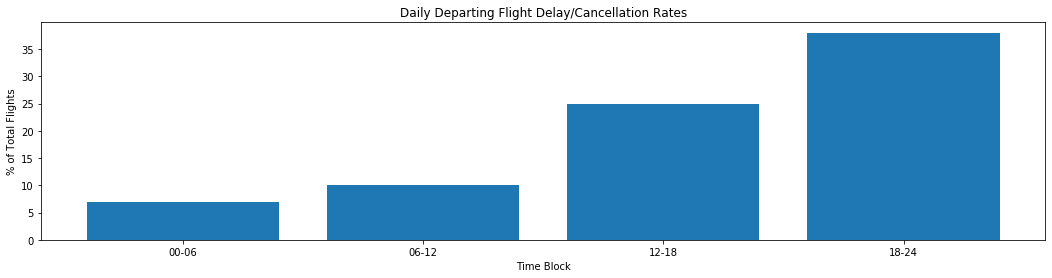

In [28]:
del_flts = f_del_flts(df.copy(), 'DEP_BLOCK', 'DEL_CANC')
del_flts = del_flts.reindex(['00-06', '06-12', '12-18', '18-24'])
plt.figure(figsize=[18,4])
plt.title('Daily Departing Flight Delay/Cancellation Rates')
plt.xlabel('Time Block')
plt.ylabel('% of Total Flights')
plt.bar(del_flts.index, del_flts)
plt.xticks(del_flts.index)
plt.show()

# 4) Modeling the Data

In [29]:
#Import libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [30]:
#Construct the datasets for features (X) and results (y)
mask = (df['ORIGIN']=="EWR")
X = df[mask][['CARRIER_NAME', 'MONTH', 'DAY_OF_WEEK', 'DEP_BLOCK']]
y = df[mask]['DEL_CANC'] 

In [31]:
#Split total data set into Training (80%) and Test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [32]:
#Create transformer object to encode categorical variables
ct = ColumnTransformer([("onehot", OneHotEncoder(sparse=False, categories='auto'), 
                         ['CARRIER_NAME', 'MONTH', 'DAY_OF_WEEK', 'DEP_BLOCK'])], remainder='passthrough') 

#Encode categorical features to create "dummy" variables
ct.fit(X)
X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)

In [33]:
#Instantiate and fit the Gradient Boosting Classifier to the Training data set
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train_trans, y_train)

#Print accuracy results of model on both Training and Test sets.
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train_trans, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test_trans, y_test)))

Accuracy on training set: 0.778
Accuracy on test set: 0.785


In [34]:
#Test my upcoming flight to determine probability that it will be delayed/cancelled.
#Airline=United Air Lines Inc.; Month=11; DayOfWeek=2; Dep_Block=12-18.
col = ['CARRIER_NAME', 'MONTH', 'DAY_OF_WEEK', 'DEP_BLOCK']
flight = ['United Air Lines Inc.', 11, 2, '12-18']
test = pd.DataFrame([flight], columns=col)
test_trans = ct.transform(test)
pred = gbrt.predict(test_trans)[0]
prob = gbrt.predict_proba(test_trans)[0][pred]

print("Model predicts result of '{0}' with {1}% certainty.".format(['On-Time', 'Delayed'][pred], int(round(prob*100,0))))

Model predicts result of 'On-Time' with 79% certainty.


# 5) Evaluate the Results

While it appears to be great that the model certainty is 79%, it's actually not impressive because the overall On-Time rate of all flights is 78%.  Using specific feature such as Airline, Month, Day of Week, and Time of Day we did gain an additional 1%.  I would like to continue evaluating additional features such as "Destination" and "Holidays" and "Distance of Previous Leg by Tail Number" to see if there are correlations that can further improve the model's ability to predict delayed flights.